# シンプルなRNNの実装
PyTorchを使って、シンプルな再帰型ニューラルネットワーク（RNN）を実装します。  
RNNにノイズ付きサインカーブを学習させて、1つ先の未来を予測することによる曲線の描画を行います。


## 訓練用データの作成
まずは、サインカーブに乱数でノイズを加えてRNNに用いる訓練用のデータを作成します。

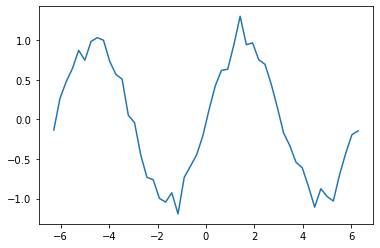

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))  # sin関数に乱数でノイズを加える
plt.plot(sin_x, sin_y)
plt.show()

このようなノイズ付きサインカーブの一部を切り取って入力の時系列とし、次の値を予測するようにRNNを訓練します。    
sin波自体は単純な時系列データですが、このようなsin波をニューラルネットワークで学習することができれば、例えば音声認識などに応用することも可能です。  
今回の扱う対象はシンプルですが、現実社会で広く応用が可能することができます。

## データの前処理
入力、正解データをRNNに適した形に整えます。  
時系列から次の値を予測できるように、時系列を入力として正解はその1つ後の値とします。 

In [6]:
import torch
from torch.utils.data import DataLoader

n_time = 10  # 時系列の数
n_sample = len(sin_x)-n_time  # サンプル数

input_data = np.zeros((n_sample, n_time, 1))  # 入力
correct_data = np.zeros((n_sample, 1))  # 正解
for i in range(n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 正解は入力よりも一つ後

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)  # DataLoaderの設定

## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
RNNは`nn.RNN`を使って実装することができます。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(  # RNN層
            input_size=1,  # 入力サイズ
            hidden_size=64,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(64, 1)  # 全結合層

    def forward(self, x):
        y_rnn, h = self.rnn(x, None)  # hは次の時刻に渡される値、 Noneでその初期値が0に
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
訓練したモデルを使い、直近の時系列を使った予測結果を次々と時系列に加えていくことにより、曲線が生成されます。  
学習が進むとともに次第にサインカーブが生成されるようになりますが、曲線は一定のエポック間隔でグラフとして描画されます。  

Epoch: 0 Loss_Train: 0.4489413857460022


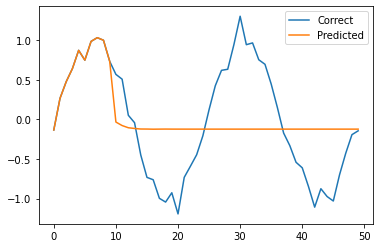

Epoch: 2 Loss_Train: 0.36585128903388975


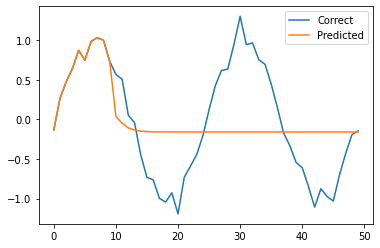

Epoch: 4 Loss_Train: 0.29533208906650543


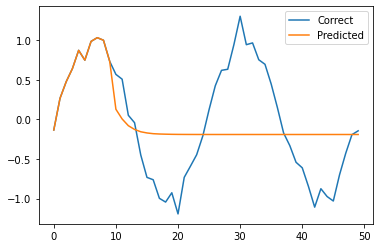

Epoch: 6 Loss_Train: 0.23659573644399642


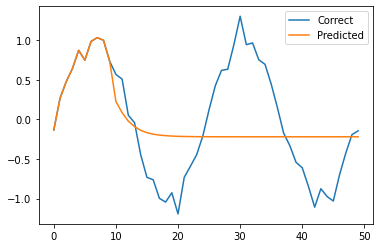

Epoch: 8 Loss_Train: 0.19141040444374086


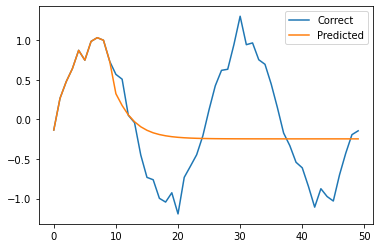

Epoch: 10 Loss_Train: 0.159626305103302


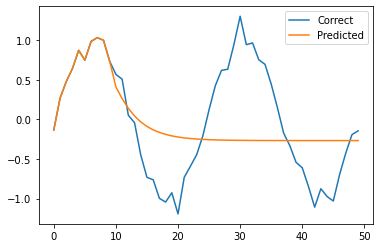

Epoch: 12 Loss_Train: 0.13802487254142762


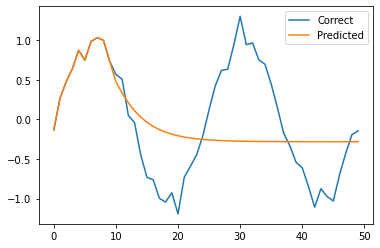

Epoch: 14 Loss_Train: 0.12254239618778229


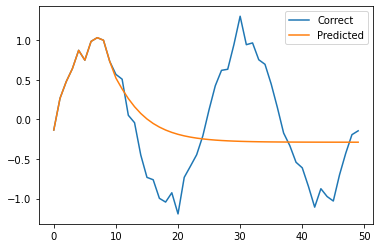

Epoch: 16 Loss_Train: 0.11026521623134614


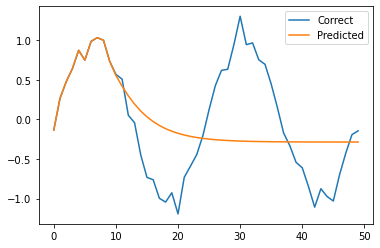

Epoch: 18 Loss_Train: 0.09959714114665985


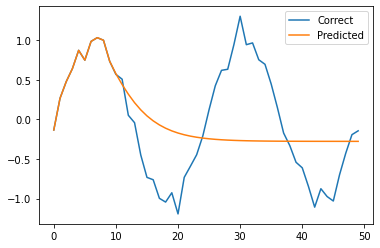

Epoch: 20 Loss_Train: 0.08971297666430474


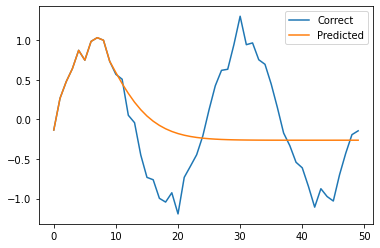

Epoch: 22 Loss_Train: 0.08015377223491668


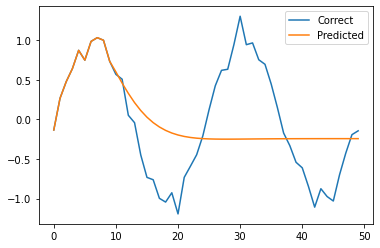

Epoch: 24 Loss_Train: 0.0706583395600319


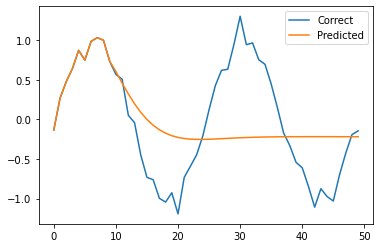

Epoch: 26 Loss_Train: 0.06113199666142464


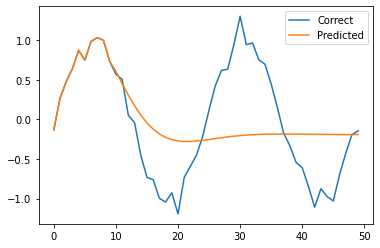

Epoch: 28 Loss_Train: 0.05167902819812298


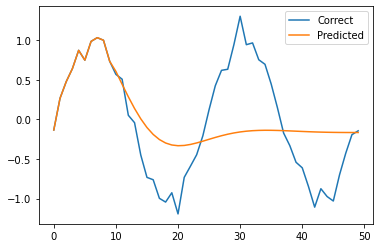

Epoch: 30 Loss_Train: 0.042642063647508624


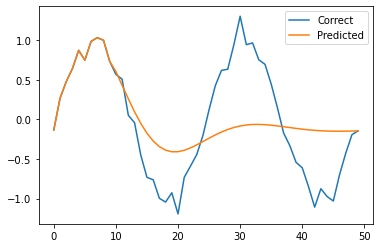

Epoch: 32 Loss_Train: 0.03457116484642029


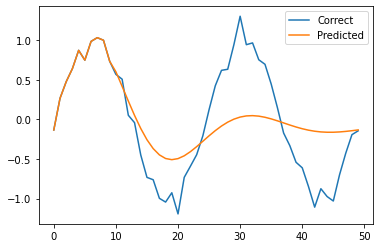

Epoch: 34 Loss_Train: 0.028046295419335364


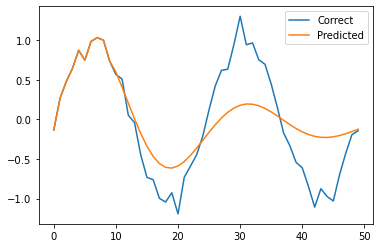

Epoch: 36 Loss_Train: 0.023391408286988734


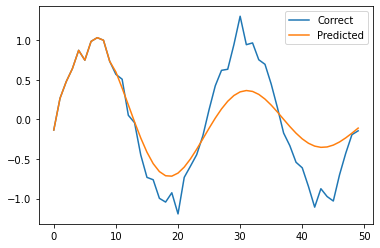

Epoch: 38 Loss_Train: 0.02049525808542967


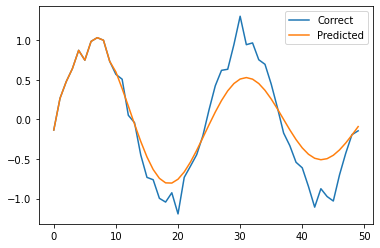

Epoch: 40 Loss_Train: 0.01891413014382124


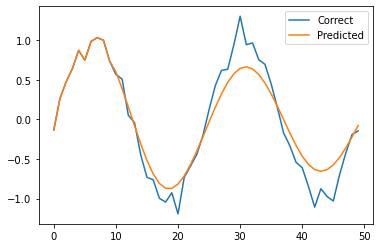

Epoch: 42 Loss_Train: 0.018139031901955604


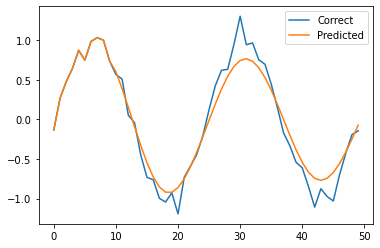

Epoch: 44 Loss_Train: 0.017784636095166208


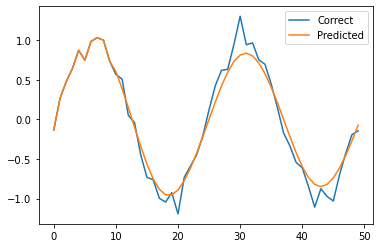

Epoch: 46 Loss_Train: 0.017624529544264078


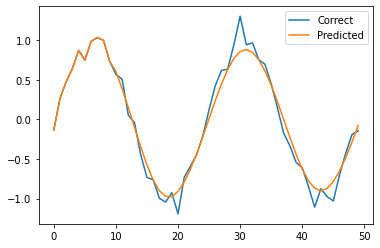

Epoch: 48 Loss_Train: 0.01754643740132451


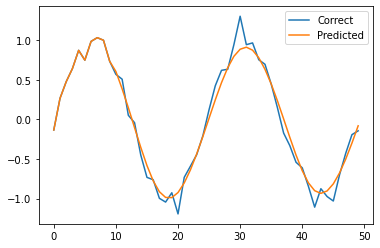

In [8]:
from torch import optim

# 二乗和誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01

# 損失のログ
record_loss_train = []

# 学習
for i in range(50):  # 50エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%2 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0].reshape(-1)) # 最初の入力
        for i in range(n_sample):
            x = torch.tensor(predicted[-n_time:])  # 直近の時系列を取り出す
            x = x.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            y = net(x)
            predicted.append(y[0].item())  # 予測結果をpredictedに追加する

        plt.plot(range(len(sin_y)), sin_y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

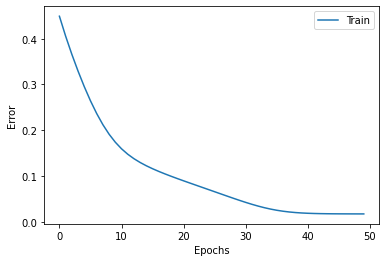

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

滑らかに誤差が減少していることが確認できます。

# 発展

RNNは長時間記憶を保持できないため, LSTMの方が良い ⇨ RNNの全結合層がゲートのあるLSTM層に変わる